**Author:** Udval Oyunsaikhan  
**Date:** 20 Apr, 2025  
**Contact:** [LinkedIn](https://www.linkedin.com/in/o-udval/)  
**Submission Video:** [Youtube](https://youtu.be/SGshgry_PQA)

<img src="https://raw.githubusercontent.com/UdvalO/ai_agent_fake_review/main/poster.png" alt="Poster" width="1000"/>

# Fake Review Detection Agent
This agent is designed to automatically detect potentially fake online reviews by analyzing both their content similarity to known fake/real examples and their writing style. It uses a k-Nearest Neighbors search on review embeddings stored in ChromaDB for similarity analysis and a Gemini LLM to assess linguistic patterns indicative of AI generation. The LangGraph workflow orchestrates these distinct analysis steps in a defined sequence, combining their outputs to produce a final prediction (Fake/Real) with a supporting explanation.

So, in building this fake review detector, I really leaned into a few key GenAI techniques that I learned from the course:
- **Embeddings:** I used Gemini's text-embedding-004 model to turn the text of each review into a numerical vector, capturing its semantic meaning. This was crucial for comparing reviews.
- **Vector Database & Search:** I stored these review embeddings in ChromaDB. This allowed me to quickly search for and find the most similar training reviews (k-Nearest Neighbors) when analyzing a new one.
- **Structured Output (via Prompting):** For the stylistic analysis, I carefully prompted the Gemini LLM to classify the writing as 'Bot' or 'Human' and provide an explanation, specifically requesting it return the results in a consistent format ("Classification: ...", "Explanation: ..."). I then parsed this structured text in my code.
- **Agents (with LangGraph):** Finally, I used LangGraph to tie everything together. I built an agent workflow where the state (the review and analysis results) automatically flows through distinct steps: first the k-NN check, then the LLM style analysis, and finally a node to combine these signals into the final Fake/Real prediction.

📌 Check out the explanation [video](https://youtu.be/SGshgry_PQA) where I walk through the code step by step, with visuals and reasoning!🎥

## Implementation
### 1. Set-up

First things first, gotta get the tools ready! We need google-genai to talk to the Gemini models (for both embeddings and the text analysis), chromadb to act as our vector database for finding similar reviews, and datasets to easily load our training/testing data. Later on, you see installs specifically for langgraph which we use to structure the different steps of our detection process into a neat workflow or "agent". Ideally we would like to work with only google-genai, but I was running into error in the embedding section and needed to work with google-generativeai.

In [2]:
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"
!pip install datasets
!pip install --upgrade google-generativeai google-api-core
!pip install chromadb google-generativeai

In [3]:
from google import genai
from google.genai import types

from IPython.display import Markdown

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

#### Automated Retry
This codelab sends a lot of requests, so set up an automatic retry that ensures your requests are retried when per-minute quota is reached.

In [5]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

###  2. Data Loading and Preparation
This is where we get our hands on the data. I'm using the datasets library to pull down the Fake Reviews Dataset. To make things run faster for this demo, I'm just taking a random **10%** sample. Then, standard machine learning practice: I split that sample into a training set (to build our ChromaDB database) and a test set (to evaluate the agent later). X holds the review features (category, rating, text), and y holds the actual 'Fake' (1) or 'Real' (0) labels.

#### About the Dataset

The [Fake Reviews Dataset](https://huggingface.co/datasets/theArijitDas/Fake-Reviews-Dataset) by theArijitDas is a curated collection designed for training and evaluating models in fake review detection. It comprises approximately 40,526 product reviews, evenly split between:
 - 20,000 real reviews: Authentic, human-written product reviews.
 - 20,000 fake reviews: AI-generated reviews created using language models.

**Each entry includes:**
- Category: Product category (e.g., Home_and_Kitchen).
- Rating: Numerical rating associated with the review.
- Text: The content of the review.
- Label: Binary indicator where 0 denotes a real review and 1 denotes a fake review.​


In [6]:
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load dataset
dataset = load_dataset("theArijitDas/Fake-Reviews-Dataset")

# Convert the train split to a DataFrame
df = pd.DataFrame(dataset["train"])

# Reducing the data set to 10% (4000) of original data for ease 
df_reduced = df.sample(frac=0.1, random_state=42)

# Split into train and test (80% train, 20% test)
train_df, test_df = train_test_split(df_reduced, test_size=0.2, random_state=42)

# Check the first few rows of each
print("Train data:")
print(train_df.shape)

print("\nTest data:")
print(test_df.shape)

y_train = train_df["label"]
y_test = test_df["label"]
X_train = train_df.drop(columns=["label"])
X_test = test_df.drop(columns=["label"])

X_train.head()

Train data:
(3242, 4)

Test data:
(811, 4)


,category,rating,text
23072,Pet_Supplies,4.0,The pellets are a bit larger than I would have...
39013,Clothing_Shoes_and_Jewelry,5.0,"Light Linen, fresh and comfortable. True to si..."
27667,Kindle_Store,5.0,I read the HvZ series and it kept me engaged. ...
20727,Pet_Supplies,5.0,Phenomenal leash and locking mechanism!! I lo...
31070,Books,4.0,"I liked it . However, I did not understand why..."


In [7]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for m in client.models.list():
    if m.supported_actions and "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


###  3. Embedding Function Definition
We need a way to convert the text reviews into numerical representations (embeddings) so we can compare them for similarity.
ChromaDB lets us define a custom function for this. So, I created the GeminiEmbeddingFunction class. 
It uses the google-geneai library's embed_content function (specifically with the text-embedding-004 model). 
It's designed to work with ChromaDB and has a document_mode switch: True uses the retrieval_document 
task type (ideal for indexing the reviews we store), and False uses retrieval_query (ideal for embedding a new review we 
want to check). I also added some basic error handling and retry logic from google.api_core.

In [8]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry
from google.api_core.exceptions import ResourceExhausted, ServiceUnavailable
import google.generativeai as genai
from google.genai import types

# Retry handler
is_retriable = lambda e: isinstance(e, (ResourceExhausted, ServiceUnavailable))

class GeminiEmbeddingFunction(EmbeddingFunction):
    def __init__(self):
        self.document_mode = True
        self.model_name = "models/text-embedding-004"

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        task_type = "retrieval_document" if self.document_mode else "retrieval_query"
        embeddings = []

        for text in input:
            try:
                response = genai.embed_content(
                    model=self.model_name,
                    content=text,
                    task_type=task_type
                )
                embeddings.append(response["embedding"])
            except Exception as e:
                print(f"Error embedding content: {e}")
                embeddings.append([0.0] * 768)

        return embeddings

### 4. Vector Database Setup (ChromaDB Initialization and Population)
This is where we build the "memory" for the similarity check (k-NN). I initialize ChromaDB, telling it to save the database locally in the ./chromadb folder so we don't lose it. I create a "collection" (like a table) called fakereviewdb and tell it to use our custom GeminiEmbeddingFunction to generate embeddings. Then, I take all the reviews from the training data (X_train), combine their category, rating, and text into single strings, and add them to the ChromaDB collection. Crucially, for each review added, I also store its true label (Fake/Real) in the metadatas field. This metadata is key for the k-NN prediction step later.

In [10]:
import chromadb

genai.configure(api_key=GOOGLE_API_KEY)

# Initialize ChromaDB client
chroma_client = chromadb.PersistentClient(path="./chromadb")
DB_NAME = "fakereviewdb"

# Create embedding function instance
embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

# Get or create a collection in ChromaDB
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

# --- Prepare data for adding ---
documents = X_train.apply(lambda row: f"Category: {row['category']}. Rating: {row['rating']}. Review: {row['text']}", axis=1).tolist()
ids = [f"train_{i}" for i in range(len(documents))]

# *** Create metadata including the labels ***
train_labels = y_train.tolist()
metadatas = [{"label": label} for label in train_labels]

print("Preparing to re-populate ChromaDB with combined text...")

try:
    chroma_client.delete_collection(name=DB_NAME)
    print(f"Collection '{DB_NAME}' deleted.")
except Exception as e:
    print(f"Collection '{DB_NAME}' might not exist, proceeding. Error if any: {e}")

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

print(f"Adding/Updating {len(documents)} documents...")
db.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids
)
print(f"{len(documents)} documents processed.")

print("Training data embedding complete (including labels as metadata).")

print(f"New collection count: {db.count()}")

Preparing to re-populate ChromaDB with combined text...
Collection 'fakereviewdb' deleted.
Adding/Updating 3242 documents...
3242 documents processed.
Training data embedding complete (including labels as metadata).
New collection count: 3242


### 5. LLM Setup (genai.GenerativeModel, Prompt Template)
Now setting up the other part of our detection: the stylistic analysis using a powerful language model. I initialize the gemini-1.5-pro model. Then, I define LLM_ANALYSIS_PROMPT_TEMPLATE. This prompt is carefully written to guide the LLM. It specifically asks it to ignore what the review says and focus only on how it's written – looking for tells like weird phrasing, repetition, generic statements, etc., to classify the style as 'Bot' or 'Human'. Asking for a specific output format makes parsing easier.

In [ ]:
# Setting up the LLM component for style analysis.
LLM_MODEL_NAME = "gemini-1.5-pro"
llm_model = None

try:
    llm_model = genai.GenerativeModel(LLM_MODEL_NAME)
    print(f"Initialized LLM: {LLM_MODEL_NAME}")
except Exception as e:
    print(f"ERROR: Failed to initialize LLM '{LLM_MODEL_NAME}'. Check API key/permissions. Linguistic analysis will be skipped. Error: {e}")

# Prompt: It focuses the LLM on *style*, not content truthfulness.
LLM_ANALYSIS_PROMPT_TEMPLATE = """
Analyze the writing style of the following review text to determine if it seems more likely generated by a bot/AI or written by a human.

Focus ONLY on these linguistic patterns:
- Does it use unnatural phrasing or non-standard sentence structures?
- Is there excessive repetition of words or phrases?
- Are there unusual grammar mistakes beyond typical typos?
- Does it make overly generic statements without specific details?
- Is the word order strange or syntax awkward?
- Does it lack personality, sound overly formal, or use fake-sounding excessive enthusiasm?

Review Text (includes category and rating):
\"\"\"
{review_text}
\"\"\"

Based ONLY on the writing style and the patterns above:
1. Classify the text as either 'Bot' or 'Human'.
2. Provide a brief explanation (1-2 sentences) for your classification, mentioning specific patterns observed if classified as 'Bot'.

Output Format:
Classification: [Bot or Human]
Explanation: [Your brief explanation]
"""

### 6. LLM Analysis Function (get_llm_linguistic_assessment)
This function orchestrates the call to the LLM. It takes the review text, inserts it into our prompt template, sends it to the initialized llm_model, and gets the response. It then includes logic to parse the LLM's text response to reliably extract the 'Classification' (Bot/Human) and the 'Explanation'. It also handles cases where the LLM might not respond in the exact format expected or if the LLM wasn't initialized correctly, returning "Error" or "Skipped" status where needed. The @retry.Retry decorator makes the API call more resilient to temporary issues.

In [ ]:
# Re-use the retry logic if needed for LLM calls
@retry.Retry(predicate=is_retriable, initial=1.0, maximum=10.0, multiplier=2.0)
def get_llm_linguistic_assessment(review_text: str) -> tuple[str, str]:
    """
    Uses the configured LLM to assess the linguistic style.

    Returns:
        A tuple: (classification, explanation). Defaults to ('Error', 'LLM analysis failed').
    """
    if llm_model is None:
        return "Skipped", "LLM not available"

    prompt = LLM_ANALYSIS_PROMPT_TEMPLATE.format(review_text=review_text)
    try:
        # Adjust generation config as needed (e.g., temperature for creativity)
        response = llm_model.generate_content(prompt)

        # print("-" * 10 + " RAW LLM RESPONSE " + "-" * 10)
        # print(response.text)
        # print("-" * 30)

        # --- REVISED PARSING LOGIC ---
        classification = "Error"
        explanation = "LLM response parsing failed"

        if response.text:
            text_response = response.text.strip()
            lines = text_response.split('\n')
            
            found_classification = False
            found_explanation = False

            for line in lines:
                line_stripped = line.strip()
                if line_stripped.lower().startswith("classification:"):
                    parts = line_stripped.split(":", 1)
                    if len(parts) > 1:
                        classification = parts[1].strip().capitalize()
                        found_classification = True
                elif line_stripped.lower().startswith("explanation:"):
                    parts = line_stripped.split(":", 1)
                    if len(parts) > 1:
                        explanation = parts[1].strip()
                        found_explanation = True

                # Stop if both found to be slightly more efficient
                if found_classification and found_explanation:
                    break

            # If classification was found but explanation wasn't explicitly found
            if found_classification and not found_explanation:
                explanation = "LLM provided classification but no distinct explanation line found."

            # If neither was found, use the raw text as explanation for debugging
            if not found_classification and not found_explanation:
                explanation = f"Could not parse classification or explanation from: {text_response[:150]}..."

        # Validate classification value after parsing
        if classification not in ["Bot", "Human"]:  
            explanation = f"LLM returned invalid classification value: '{classification}'. Original text: {response.text[:100]}..."
            classification = "Error"

        return classification, explanation

    except Exception as e:
        print(f"ERROR during LLM linguistic analysis for text '{review_text[:50]}...': {e}")
        return "Error", f"LLM analysis failed: {e}"


print("LLM analysis function 'get_llm_linguistic_assessment' (with context-aware prompt) defined.")

#--- Test the LLM function (Optional) ---
test_llm_review = "Syntax strange this product is. Repeat repeat repeat. Good maybe?"
llm_class, llm_expl = get_llm_linguistic_assessment(test_llm_review)
print(f"\nLLM Test - Classification: {llm_class}, Explanation: {llm_expl}")

### 7. k-NN Prediction Function (predict_review_label)
This function performs the similarity-based prediction. It takes a new review text, temporarily sets our embedding function to "query" mode, and uses db.query to ask ChromaDB for the k==5 most similar reviews from the training data we stored earlier. It then looks at the 'label' stored in the metadata of those neighbors, counts which label ('Fake' or 'Real') appears most often, and returns that majority label as the prediction (1 or 0). The finally block is important to switch the embedding function back to "document" mode.

In [12]:
K_NEIGHBORS = 5
print(f"Using k = {K_NEIGHBORS} neighbors for k-NN prediction.")

def predict_review_label(review_text_combined: str, k: int = K_NEIGHBORS) -> int:
    """
    Predicts the label for a single combined review text using k-NN search.
    Returns 0 for Real, 1 for Fake.
    """
    embed_fn.document_mode = False

    try:
        results = db.query(
            query_texts=[review_text_combined],
            n_results=k,
            include=['metadatas']
        )

        if not results or not results.get('ids') or not results['ids'][0]:
             return 0

        neighbor_metadatas = results['metadatas'][0]
        neighbor_labels = [metadata.get('label') for metadata in neighbor_metadatas if metadata and 'label' in metadata]

        if not neighbor_labels:
             return 0

        vote_counts = Counter(neighbor_labels)
        predicted_label = vote_counts.most_common(1)[0][0]
        return int(predicted_label)

    except Exception as e:
        print(f"ERROR during k-NN prediction for text '{review_text_combined[:50]}...': {e}")
        return 0
    
        embed_fn.document_mode = True

print("k-NN prediction function 'predict_review_label' defined (operates on combined text).")

Using k = 5 neighbors for k-NN prediction.
k-NN prediction function 'predict_review_label' defined (operates on combined text).


### 8. (Optional: Original Agent Function run_fake_review_agent)
Before using LangGraph, I had this function to tie everything together. It called the k-NN function, then the LLM function, and finally used some simple if/else logic (basically, if k-NN predicts Fake OR the LLM predicts Bot style, then classify as Fake) to combine the results and create an explanation string. We don't call this directly in the LangGraph version, but its logic is replicated in the 'combiner' node.

In [13]:
def run_fake_review_agent(review_text_combined: str, k: int = K_NEIGHBORS) -> dict:
    """
    Orchestrates k-NN and LLM analysis on combined text.
    (Logic remains the same as previous Cell 7)
    Returns:
        A dictionary containing: 'prediction', 'explanation',
        'knn_prediction_label', 'llm_assessment', 'llm_explanation'.
    """
    final_prediction_label = "Real Review"
    explanation = ""
    knn_pred_val = 0
    llm_assessment = "Skipped"
    llm_explanation = "N/A"

    # --- 1. k-NN Prediction ---
    try:
        # Passes the combined text to the k-NN function
        knn_pred_val = predict_review_label(review_text_combined, k=k)
        knn_label_str = "Fake" if knn_pred_val == 1 else "Real"
    except Exception as e:
        print(f"ERROR during k-NN prediction step in agent: {e}")
        knn_label_str = "Error"

    # --- 2. LLM Linguistic Analysis ---
    try:
        # Passes the combined text to the LLM function
        llm_assessment, llm_explanation = get_llm_linguistic_assessment(review_text_combined)
    except Exception as e:
        print(f"ERROR during LLM analysis step in agent: {e}")
        llm_assessment = "Error"
        llm_explanation = f"LLM analysis failed: {e}"

    # --- 3. Combine Predictions & Generate Explanation ---
    is_fake_knn = (knn_pred_val == 1)
    is_bot_llm = (llm_assessment == "Bot")

    if is_bot_llm and is_fake_knn:
        final_prediction_label = "Fake Review"
        explanation = f"Reasoning: Content similarity suggests fake (k-NN). Writing style also shows bot-like patterns: {llm_explanation}"
    elif is_bot_llm:
        final_prediction_label = "Fake Review"
        explanation = f"Reasoning: Writing style shows bot-like patterns: {llm_explanation}"
    elif is_fake_knn:
        final_prediction_label = "Fake Review"
        explanation = "Reasoning: Content similarity suggests fake (k-NN)."
        if llm_assessment == "Human": explanation += " Linguistic style appears human."
        elif llm_assessment != "Real": explanation += f" Linguistic style analysis result: {llm_assessment}." # Include Skipped/Error
    else: # Both Real/Human or non-fake errors
        final_prediction_label = "Real Review"
        explanation = "Reasoning: Review does not strongly match fake content patterns and linguistic style appears human."
        if knn_label_str == "Error" or llm_assessment == "Error" or llm_assessment == "Skipped":
             explanation += f" (Note: k-NN status: {knn_label_str}, LLM status: {llm_assessment})."

    return {
        "prediction": final_prediction_label,
        "explanation": explanation,
        "knn_prediction_label": knn_label_str,
        "llm_assessment": llm_assessment,
        "llm_explanation": llm_explanation if is_bot_llm else "N/A"
    }

print("Combined agent logic function 'run_fake_review_agent' defined (operates on combined text).")

Combined agent logic function 'run_fake_review_agent' defined (operates on combined text).


In [18]:
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install --upgrade google-generativeai google-api-core chromadb datasets

  Using cached google_generativeai-0.8.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
Using cached google_generativeai-0.8.5-py3-none-any.whl (155 kB)
Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl (1.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 67.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: starlette
    Found existing installation: starlette 0.46.2
    Uninstalling starlette-0.46.2:
      Successfully uninstalled starlette-0.46.2
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.115.12
    Uninstalling fastapi-0.115.12:
      Successfully uninstalled fastapi-0.115.12
  Attempting uninstall: google-ai-gener

### 9. LangGraph Agent Implementation (State, Nodes, Graph)
This is where we structure the detection process using LangGraph.
- **ReviewAgentState:** I define the "memory" or state for our agent. It holds the input review and slots for the results from each step (k-NN label, LLM assessment, etc.) and the final prediction/explanation.
- **Nodes (knn_predictor_node, etc.):** I define Python functions that represent each distinct step in our process. Each node function takes the current state, performs its task (like calling predict_review_label or get_llm_linguistic_assessment), and returns a dictionary containing only the updates to the state.
- **Graph (StateGraph, add_node, add_edge):** I build the workflow. I create a StateGraph, add our nodes to it, define the starting point (knn_predictor), and then specify the sequence using add_edge. In this case, it's a simple linear flow: k-NN -> LLM -> Combiner -> END.
- **compile():** This turns the graph definition into a runnable agent object.

In [19]:
import operator
from typing import TypedDict, Annotated, Optional, Sequence
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage
from collections import Counter
import json 

# 1. Define the State for the Agent Graph
class ReviewAgentState(TypedDict):
    """Represents the state of our fake review detection agent."""
    review_text: str

    # Intermediate results
    knn_prediction_label: Optional[int]
    knn_label_str: Optional[str]
    llm_assessment: Optional[str]
    llm_explanation: Optional[str]

    # Final output
    final_prediction: Optional[str]
    final_explanation: Optional[str]

    # Error handling
    error_message: Optional[str]

In [20]:
# 2. Define the Nodes (functions that operate on the state)

def knn_predictor_node(state: ReviewAgentState) -> dict:
    """Runs the k-NN prediction and updates the state."""
    print("--- Running k-NN Predictor Node ---")
    review_text = state.get("review_text")
    if not review_text:
        print("ERROR: No review text provided to k-NN node.")
        return {"error_message": "No review text provided to k-NN node.", "knn_label_str": "Error"}

    try:
        knn_pred_val = predict_review_label(review_text, k=K_NEIGHBORS)
        knn_label_str = "Fake" if knn_pred_val == 1 else "Real"
        print(f"k-NN Prediction: {knn_label_str} ({knn_pred_val})")
        return {
            "knn_prediction_label": knn_pred_val,
            "knn_label_str": knn_label_str,
            "error_message": None
        }
    except Exception as e:
        print(f"ERROR in k-NN Node: {e}")
        return {
            "knn_prediction_label": None,
            "knn_label_str": "Error",
            "error_message": f"k-NN prediction failed: {e}"
        }

def llm_analyzer_node(state: ReviewAgentState) -> dict:
    """Runs the LLM linguistic analysis and updates the state."""
    print("--- Running LLM Analyzer Node ---")
    review_text = state.get("review_text")
    if not review_text:
        print("ERROR: No review text provided to LLM node.")
        return {"error_message": "No review text provided to LLM node.", "llm_assessment": "Error", "llm_explanation": "Missing input"}

    if llm_model is None:
         print("LLM model not available, skipping analysis.")
         return {
             "llm_assessment": "Skipped",
             "llm_explanation": "LLM not initialized",
             "error_message": state.get("error_message")}

    try:
        llm_assessment, llm_explanation = get_llm_linguistic_assessment(review_text)
        print(f"LLM Assessment: {llm_assessment}")
        # Only store LLM explanation if it's relevant (e.g., for 'Bot' or 'Error')
        explanation_to_store = llm_explanation if llm_assessment in ["Bot", "Error"] else "N/A"

        # Determine if this step introduced an error
        current_error = f"LLM analysis failed: {llm_explanation}" if llm_assessment == "Error" else None
        previous_error = state.get("error_message")
        combined_error = previous_error if previous_error and not current_error else current_error # Prioritize new error, otherwise keep old

        return {
            "llm_assessment": llm_assessment,
            "llm_explanation": explanation_to_store,
            "error_message": combined_error}
        
    except Exception as e:
        print(f"ERROR in LLM Node: {e}")
        # Combine with potential previous error
        previous_error = state.get("error_message")
        current_error = f"LLM analysis failed: {e}"
        combined_error = f"{previous_error}; {current_error}" if previous_error else current_error
        return {
            "llm_assessment": "Error",
            "llm_explanation": f"LLM analysis failed: {e}",
            "error_message": combined_error
        }

def combiner_node(state: ReviewAgentState) -> dict:
    """Combines k-NN and LLM results to produce the final output."""
    print("--- Running Combiner Node ---")
    knn_pred_val = state.get("knn_prediction_label")
    knn_label_str = state.get("knn_label_str", "Error")
    llm_assessment = state.get("llm_assessment", "Skipped")
    llm_explanation = state.get("llm_explanation", "N/A")

    final_prediction_label = "Real Review" # Default
    explanation = ""

    # Handle cases where knn_pred_val might be None due to error
    is_fake_knn = (knn_pred_val == 1) if knn_pred_val is not None else False
    is_bot_llm = (llm_assessment == "Bot")

    # Replicate the combination logic from run_fake_review_agent
    if is_bot_llm and is_fake_knn:
        final_prediction_label = "Fake Review"
        # Use the stored explanation which is only present for Bot/Error
        explanation = f"Reasoning: Content similarity suggests fake (k-NN: {knn_label_str}). Writing style also shows bot-like patterns: {llm_explanation}"
    elif is_bot_llm:
        final_prediction_label = "Fake Review"
        explanation = f"Reasoning: Writing style shows bot-like patterns: {llm_explanation}"
        if knn_label_str != "Real": explanation += f" (k-NN status: {knn_label_str})."
    elif is_fake_knn:
        final_prediction_label = "Fake Review"
        explanation = f"Reasoning: Content similarity suggests fake (k-NN: {knn_label_str})."
        if llm_assessment == "Human": explanation += " Linguistic style appears human."
        # Check llm_assessment against "Human" or "Real" (assuming Real is not a valid LLM output here)
        elif llm_assessment != "Human": explanation += f" Linguistic style analysis result: {llm_assessment}."
    else: # Both Real/Human or non-fake errors/skipped
        final_prediction_label = "Real Review"
        explanation = "Reasoning: Review does not strongly match fake content patterns based on available analysis."
        # Add more detail if components were skipped or erred
        status_notes = []
        if knn_label_str not in ["Real", "Fake"]: status_notes.append(f"k-NN status: {knn_label_str}") # e.g., Error
        if llm_assessment not in ["Human", "Bot"]: status_notes.append(f"LLM status: {llm_assessment}") # e.g., Skipped, Error
        if status_notes:
            explanation += f" (Note: {', '.join(status_notes)})."
        elif llm_assessment == "Human" and knn_label_str == "Real":
             explanation = "Reasoning: Review does not strongly match fake content patterns (k-NN: Real) and linguistic style appears human."

    print(f"Final Prediction: {final_prediction_label}")
    # Return only the final fields updated by this node
    return {
        "final_prediction": final_prediction_label,
        "final_explanation": explanation
    }


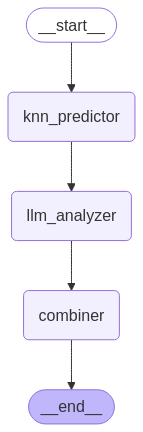

In [21]:
# 3. Define the Graph just to show the workflow
workflow = StateGraph(ReviewAgentState)

# Add the nodes
workflow.add_node("knn_predictor", knn_predictor_node)
workflow.add_node("llm_analyzer", llm_analyzer_node)
workflow.add_node("combiner", combiner_node)

# Set the entrypoint
workflow.set_entry_point("knn_predictor")

# Add edges for the sequential flow
workflow.add_edge("knn_predictor", "llm_analyzer")
workflow.add_edge("llm_analyzer", "combiner")
workflow.add_edge("combiner", END) # End the graph after combining

# Compile the graph
agent_graph = workflow.compile()

try:
    from IPython.display import Image, display
    display(Image(agent_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not draw graph: {e}. Ensure graphviz and pygraphviz are installed.")

### 10. Running the LangGraph Agent (Grand Final)
Showtime! I take a review from the test set, format it, and create the initial_state dictionary containing just this input review. Then, I call agent_graph.invoke(initial_state). LangGraph takes care of passing the state through each node in the sequence we defined (k-NN, then LLM, then Combiner). The final output (final_state) contains the accumulated results from all steps. I then print out a summary comparing the agent's prediction to the actual known label for that test review.

The example below shows that when kNN predicted "Real", the LLM was able to accurately predict it was a bot created review based on the language nuance. I perseonally find this amazing and gives many ways to improve your traditional rule based models with the complimentation of LLMs.

In [26]:
# --- Running the Agent ---
print("\n--- Testing the LangGraph Agent ---")

# Example input reviews (using the combined format)
first_row = X_test.iloc[0] # Get the first row as a Series
test_review_real = f"Category: {first_row['category']}. Rating: {first_row['rating']}. Review: {first_row['text']}"# Get first test review
test_review_fake_style = f"Category: Electronics. Rating: 1. Review: Product bad is. Not function good. Repeat repeat repeat. Unnatural syntax this review has. Do not buy this thing ever."
test_review_fake_knn = f"Category: Home_and_Kitchen. Rating: 5. Review: Absolutely amazing product! Changed my life. So versatile and easy to use. Everyone should own one. Best purchase ever!" # Generic, might match other fake ones

# --- Select a review to test ---
# Combine details from the first row of X_test
test_index = 10 # Choose a row index from X_test
test_row = X_test.iloc[test_index] # Get the row as a Series
input_category = X_test.iloc[test_index]['category']
input_rating = X_test.iloc[test_index]['rating']
input_text = X_test.iloc[test_index]['text']
actual_label_numeric = y_test.iloc[test_index] # Get the corresponding label
actual_label_str = "Fake" if actual_label_numeric == 1 else "Real"

input_review_combined = f"Category: {test_row['category']}. Rating: {test_row['rating']}. Review: {test_row['text']}"

print(f"Input Review (Index {test_index}, Actual Label: {actual_label_str}):\n{input_review_combined}\n")

# --- Prepare the initial state ---
initial_state = {"review_text": input_review_combined}

# Invoke the graph
config = {"recursion_limit": 5}
final_state = agent_graph.invoke(initial_state, config=config)

# print("\n--- Final Agent State (Full) ---")
# Pretty print the final state dictionary
# print(json.dumps(final_state, indent=2))

print("\n--- Agent Result Summary ---")
print(f"Input Review: {final_state.get('review_text')[:100]}...")
print(f"Actual Label: {actual_label_str}")
print(f"k-NN Result: {final_state.get('knn_label_str')}")
print(f"LLM Assessment: {final_state.get('llm_assessment')}")
print(f"----> Final Prediction: {final_state.get('final_prediction')}")
print(f"Explanation: {final_state.get('final_explanation')}")
if final_state.get('error_message'):
    print(f"Error Message: {final_state.get('error_message')}")


--- Testing the LangGraph Agent ---
Input Review (Index 10, Actual Label: Fake):
Category: Sports_and_Outdoors. Rating: 5.0. Review: Great little gadget to use for an emergency. Not too big or too small.

--- Running k-NN Predictor Node ---
k-NN Prediction: Real (0)
--- Running LLM Analyzer Node ---
LLM Assessment: Bot
--- Running Combiner Node ---
Final Prediction: Fake Review

--- Agent Result Summary ---
Input Review: Category: Sports_and_Outdoors. Rating: 5.0. Review: Great little gadget to use for an emergency. Not...
Actual Label: Fake
k-NN Result: Real
LLM Assessment: Bot
----> Final Prediction: Fake Review
Explanation: Reasoning: Writing style shows bot-like patterns: The review uses generic phrasing ("Great little gadget," "Not too big or too small") without specific details about the product's usefulness or functionality, suggesting automated generation. The language is also simplistic and lacks personality.


## Challenges Overcame

- **Getting the Core Components Right:** Initially, there were hurdles ensuring the custom GeminiEmbeddingFunction correctly interacted with the latest google-generativeai library (like the embed_content API and task_type usage). Google-genai was keep giving error when traying to use embed_content(). I also refined the k-NN prediction function (predict_review_label) to reliably switch the embedding function between 'query' and 'document' modes using a finally block, preventing potential issues later on.
  
- **Structuring with LangGraph:** Translating the sequential logic (run k-NN, run LLM, combine) into the LangGraph framework was the main structural task. This involved defining a clear State dictionary (ReviewAgentState) to hold and pass information between steps, and then wrapping my existing k-NN and LLM functions within specific 'node' functions designed to update this state correctly (returning dictionaries, not just values). Understanding how nodes access shared resources like embed_fn and db was also key, for this notebook, using the global scope worked best.

- **Debugging Runtime Errors:** A significant runtime challenge popped up as a TypeError when preparing test data right before invoking the agent. The traceback helped pinpoint that I was incorrectly using pandas .apply() on a single row (a Series) instead of directly accessing its elements; correcting this data access method resolved the error and allowed the agent to run successfully.


### Next Steps

Due to time limitations and knowledge that I learned from the course, I am presenting here the initial version of my Agent. In future, I would like to keep improving the Agent with following capabilities:

- Integrate:
  - User Behavior Analysis
  - Review Velocity/Timing
  - Review Network Analysis
  - Sentiment Analysis
  - Image Analysis
- Fine-tune smaller models
- Add feedback loop
- Weighted Voting: Instead of a simple majority vote, weight neighbor votes by their distance/similarity score (closer neighbors get a stronger vote).

When cost and regular maintainance is not an issue, the Agent can compare the review with general sentiment, common themes, or even stylistic patterns observed in reviews for similar products on external platforms and make decision. It requires adding data retrieval tools and analysis nodes, then updating the workflow and combination logic to leverage this new information source.